# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발

- 암환자 유전체 데이터의 변이 정보를 활용하여 암종을 분류하는 AI 모델을 개발
- 암환자 유전체 변이 정보을 사용하여 특정 변이 정보를 바탕으로 암종을 정확하게 분류할 수 있는 AI 알고리즘을 개발


- **ID**
  - 환자 또는 데이터 샘플의 고유 식별자
  - 예를 들어, `TRAIN_0000`은 첫 번째 환자를 나타냅니다.
- **SUBCLASS**
  - 해당 환자의 암종
  - 예를 들어, `KIPAN`, `SARC`, `SKCM` 등은 다양한 암종을 나타냄
- **유전자 정보(A2M, AAAS, AADAT 등)**
  - 유전자 이름을 나타내며, 각 열은 해당 유전자에서 관찰된 변이를 기록
  - 예를 들어, `R895R`과 같은 변이는 특정 위치에서 발생한 유전자 변이를 나타냄
  - 만약 변이가 없다면 "WT"(wild type, 정상형)를 의미

# 0. 데이터 및 라이브러리 불러오기

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!unzip -qq '/content/drive/MyDrive/0000/dacon_biodata/open.zip'

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# 1. 데이터 확인

In [41]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [42]:
train.head(5)

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,R895R,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [43]:
test.head(5)

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


## EDA

In [44]:
train.describe(), len(train)

(                ID SUBCLASS   A2M  AAAS AADAT AARS1  ABAT ABCA1 ABCA2 ABCA3  \
 count         6201     6201  6201  6201  6201  6201  6201  6201  6201  6201   
 unique        6201       26   141    43    25     1    48   145   119   129   
 top     TRAIN_6200     BRCA    WT    WT    WT    WT    WT    WT    WT    WT   
 freq             1      786  6053  6157  6176  6201  6153  6045  6079  6069   
 
         ... ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4  ZPBP  ZW10 ZWINT   ZYX  
 count   ...   6201   6201   6201   6201  6201  6201  6201  6201  6201  6201  
 unique  ...    168     69     33     27   126    61    53    53    35    41  
 top     ...     WT     WT     WT     WT    WT    WT    WT    WT    WT    WT  
 freq    ...   6025   6131   6169   6174  6065  6139  6143  6142  6166  6159  
 
 [4 rows x 4386 columns],
 6201)

In [45]:
train.info

<bound method DataFrame.info of               ID SUBCLASS    A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN     WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  R895R   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG     WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...    ...  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT     WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM     WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10  ZWINT ZYX  
0        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
1        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
2        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
3        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
4        WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
...     ...    ...    ...    ...   ...   ...  ...  ...    ...  ..  
6196     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6197     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6198     WT     WT     WT     WT    WT    WT   WT   WT  T181S  WT  
6199     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  
6200     WT     WT     WT     WT    WT    WT   WT   WT     WT  WT  

[6201 rows x 4386 columns]>

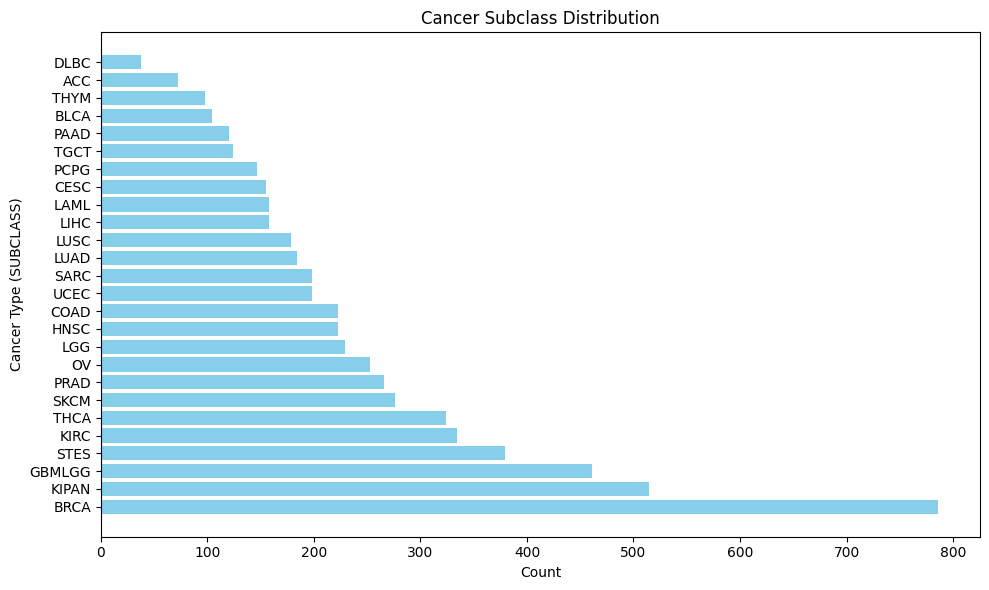

In [46]:
# 암종을 종류별로 확인
df = pd.DataFrame(train.SUBCLASS.value_counts())

plt.figure(figsize=(10, 6))
plt.barh(df.index, df['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Cancer Type (SUBCLASS)')
plt.title('Cancer Subclass Distribution')
plt.tight_layout()

# 2. 데이터 전처리


1. **데이터 전처리**:
   - 변이 정보를 수치적으로 변환
   - 각 샘플이 포함하는 유전자 변이의 개수 또는 중요한 유전자의 변이 패턴을 확인하여 데이터의 특성을 분석

2. **특징 선택**:
   - 전체 유전체 변이 정보 중에서 암종 분류에 가장 유의미한 변이 정보를 선택하는 것이 중요


In [47]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


In [48]:
# x 의 경우도 범주형으로 구성되어 있어, 알맞은 인코딩 필요
X = train.drop(columns=['SUBCLASS', 'ID'])
y_subclass = train['SUBCLASS']

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_encoded = X.copy()
X_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_subclass, test_size=0.2, random_state=42)

# 3. Modeling - Baseline

In [50]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

In [51]:
model.fit(X_encoded, y_subclass)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [52]:
test_X = test.drop(columns=['ID'])
X_encoded = test_X.copy()
X_encoded[categorical_columns] = ordinal_encoder.transform(test_X[categorical_columns])

predictions = model.predict(X_encoded)
original_labels = le_subclass.inverse_transform(predictions)

In [53]:
submission["SUBCLASS"] = original_labels
submission.to_csv('./baseline_submission.csv', encoding='UTF-8-sig', index=False)

# 3. Modeling


3. **AI 모델 훈련**:
   - 데이터에서 특정 암종과 관련된 유전적 변이를 학습하는 분류 모델을 개발해야 합니다. 이를 위해서는 결정 트리, 랜덤 포레스트, 서포트 벡터 머신(SVM), 인공 신경망(ANN), 또는 심층 학습 모델을 사용할 수 있습니다.
   - 예를 들어, 유전적 변이 데이터를 입력으로 받고 각 환자의 암종을 출력하는 다중 분류 모델을 훈련할 수 있습니다.

4. **모델 평가**:
   - 훈련된 모델의 성능을 평가하기 위해, 데이터를 훈련 세트와 테스트 세트로 분리합니다.
   - 성능 평가 지표로는 정확도, F1 점수, AUC-ROC 등을 사용할 수 있습니다.

**예시 분석**:
- `TRAIN_0002`의 경우, 암종 `SKCM`과 `R895R` 변이를 가지고 있습니다. 다른 유전자는 모두 "WT"입니다. 이런 유전적 변이가 SKCM(피부암)과 어떤 연관성이 있는지 모델이 학습하게 됩니다.
- `TRAIN_0001`은 SARC(육종) 암종에 속하며, 모든 유전자가 "WT"로 되어 있습니다. 모델은 이런 패턴도 학습하게 될 것입니다.

이 모델을 통해 암종을 자동으로 분류하거나 특정 변이와 암의 연관성을 파악할 수 있게 됩니다.

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
# 랜덤포레스트 분류기 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X_encoded, y_subclass)

RandomForestClassifier(random_state=42)

# 4. 검증

In [27]:
X_test = test.drop(columns=['ID'])
X_test = X_test.dropna() # 결측치 보유

categorical_columns = X_test.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_test = X_test.copy()
X_test[categorical_columns] = ordinal_encoder.fit_transform(X_test[categorical_columns])
X_test

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
1,70.0,20.0,19.0,18.0,21.0,53.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,25.0,28.0,26.0,22.0,31.0
2,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
3,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
4,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
2541,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
2542,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,100.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0
2544,70.0,20.0,19.0,18.0,21.0,74.0,86.0,74.0,70.0,55.0,...,88.0,37.0,21.0,15.0,51.0,55.0,28.0,26.0,22.0,31.0


In [28]:
from sklearn.metrics import f1_score, classification_report

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# F1 스코어 계산 (macro 평균 사용)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 Score (Macro Average): {f1:.4f}')

# 분류 리포트 출력 (여기에도 F1 스코어 포함)
print(classification_report(y_test, y_pred))

NameError: name 'y_test' is not defined

# 5. 예측

In [35]:
X_test = test.drop(columns=['ID'])
#X_test = X_test.dropna() # 결측치 보유

categorical_columns = X_test.select_dtypes(include=['object', 'category']).columns
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_test = X_test.copy()
X_test[categorical_columns] = ordinal_encoder.fit_transform(X_test[categorical_columns])
X_test

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
1,99.0,30.0,23.0,31.0,27.0,74.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,32.0,37.0,40.0,31.0,38.0
2,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
3,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
4,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
2542,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,134.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0
2543,99.0,30.0,23.0,31.0,27.0,45.0,77.0,81.0,37.0,31.0,...,98.0,22.0,24.0,22.0,33.0,67.0,12.0,11.0,31.0,38.0
2544,99.0,30.0,23.0,31.0,27.0,99.0,138.0,111.0,89.0,75.0,...,119.0,46.0,24.0,22.0,74.0,67.0,37.0,40.0,31.0,38.0


In [37]:
predictions = rf_model.predict(X_test)
original_labels = le_subclass.inverse_transform(predictions)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [36]:
submission["SUBCLASS"] = original_labels

ValueError: Length of values (2418) does not match length of index (2546)